In [43]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os import mkdir, path
from sklearn.model_selection import train_test_split


# Directory to save models.
try:
    mkdir("models")
except FileExistsError:
    pass
except Exception as e:
    print("Failed to create models directory. Reason: %s", e)
    exit(1)


DATASET_PATH = "output.csv"

# Dict to store the model metrics like accuracy, f1, recall
metrics = {}

Read dataset


In [44]:
dataset = pd.read_csv(DATASET_PATH)

# Initially set the clean_dataset as dataset itself. Using two variables clean_dataset
# and dataset to retain full dataset because after cleaning dataset we lose some data.
clean_dataset = pd.read_csv(DATASET_PATH)
dataset


,frame.encap_type,frame.time_epoch,frame.len,frame.cap_len,eth.src,eth.dst,ip.version,ip.hdr_len,ip.tos,ip.id,...,ip.checksum,ip.src,ip.dst,ip.len,ip.dsfield,srcport,dstport,length,checksum,quic
0,1,1.644570e+09,75,75,38:f9:d3:18:46:54,1c:3b:f3:ae:c6:f0,4,20,NaN,0x58ed,...,0x1aaf,192.168.0.103,142.250.183.10,61,0x00,51876,443,41,0xfdc4,0
1,1,1.644570e+09,1292,1292,38:f9:d3:18:46:54,1c:3b:f3:ae:c6:f0,4,20,NaN,0xa385,...,0x3e9c,192.168.0.103,142.250.67.196,1278,0x00,55366,443,1258,0x16bf,1
2,1,1.644570e+09,1292,1292,38:f9:d3:18:46:54,1c:3b:f3:ae:c6:f0,4,20,NaN,0xa432,...,0x3def,192.168.0.103,142.250.67.196,1278,0x00,55175,443,1258,0xf2d0,1
3,1,1.644570e+09,1292,1292,1c:3b:f3:ae:c6:f0,38:f9:d3:18:46:54,4,20,NaN,0x0000,...,0xa921,142.250.67.196,192.168.0.103,1278,0x00,443,55366,1258,0x6323,1
4,1,1.644570e+09,1292,1292,1c:3b:f3:ae:c6:f0,38:f9:d3:18:46:54,4,20,NaN,0x0000,...,0xa7a1,142.250.67.196,192.168.0.103,1278,0x80,443,55175,1258,0xcc50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4962,1,1.644570e+09,579,579,1c:3b:f3:ae:c6:f0,38:f9:d3:18:46:54,4,20,NaN,0x0000,...,0x2a21,172.217.167.174,192.168.0.103,565,0x00,443,61341,545,0x519a,1
4963,1,1.644570e+09,77,77,38:f9:d3:18:46:54,1c:3b:f3:ae:c6:f0,4,20,NaN,0x2fef,...,0x3528,192.168.0.103,172.217.167.174,63,0x00,61341,443,43,0xd073,1
4964,1,1.644570e+09,232,232,1c:3b:f3:ae:c6:f0,38:f9:d3:18:46:54,4,20,NaN,0x0000,...,0x2b7c,172.217.167.174,192.168.0.103,218,0x00,443,61341,198,0xca8d,1
4965,1,1.644570e+09,75,75,38:f9:d3:18:46:54,1c:3b:f3:ae:c6:f0,4,20,NaN,0xe6bd,...,0x7e5b,192.168.0.103,172.217.167.174,61,0x00,61341,443,41,0x5d22,1


Dataset specification

Total packets: 4967
1    3378
0    1589
Name: quic, dtype: int64


/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


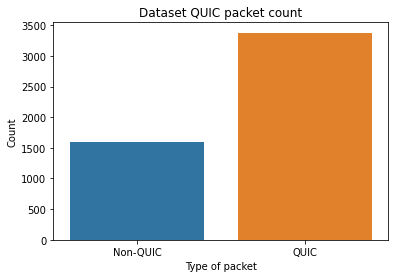

In [45]:
packet_protocol = dataset["quic"]
packet_protocol = ["QUIC" if x else "Non-QUIC" for x in packet_protocol]

print("Total packets: {0}".format(len(packet_protocol)))
print(dataset["quic"].value_counts())

chart = sns.countplot(packet_protocol)
plt.title("Dataset QUIC packet count")
plt.xlabel("Type of packet")
plt.ylabel("Count")
plt.show()

Preprocess dataset

- Extract quic column data and remove from dataset.
- Remove the string related feilds.
- Remove empty feilds


In [46]:
def preprocess(ds):

    # 1. Remove the strings columnns from dataset.
    # eth.src, eth.dst, ip.src, ip.dst, ip.tos, ip.id, ip.flags, ip.checksum, ip.dsfield, checksum
    ds.drop(
        [
            "eth.src",
            "eth.dst",
            "ip.src",
            "ip.dst",
            "ip.tos",
            "ip.id",
            "ip.flags",
            "ip.checksum",
            "ip.dsfield",
            "checksum",
        ],
        axis=1,
        inplace=True,
    )

    # 2. Remove the invalid rows ie axis=0 from the dataset.
    ds.dropna(axis=0, inplace=True)

    # 3. After deleting the rows, reset the index column and delete it.
    ds.reset_index(drop=True)

    # 4. Get the result(quic) column values and remove dataset.
    targets = list(ds["quic"].values)
    ds.drop(ds.columns[len(ds.columns) - 1], axis=1, inplace=True)

    print(ds.info())
    return ds, targets


initial_size = dataset.size
clean_dataset, targets = preprocess(clean_dataset)
final_size = clean_dataset.size

if clean_dataset.isnull().values.any():
    print("Failed to clean dataset. There are NaN/null values in dataset.")
    nan_cols = [i for i in clean_dataset.columns if clean_dataset[i].isnull().any()]
    print("Columns with null values: ", *nan_cols)
    exit(1)


print(
    "\nDataset size: {0} = {1}, Cleaned dataset size: {2} = {3}, Percentage: {4}%".format(
        dataset.shape,
        initial_size,
        clean_dataset.shape,
        final_size,
        round(100 - (final_size / initial_size) * 100, 2),
    )
)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4967 entries, 0 to 4966
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   frame.encap_type  4967 non-null   int64  
 1   frame.time_epoch  4967 non-null   float64
 2   frame.len         4967 non-null   int64  
 3   frame.cap_len     4967 non-null   int64  
 4   ip.version        4967 non-null   int64  
 5   ip.hdr_len        4967 non-null   int64  
 6   ip.flags.rb       4967 non-null   int64  
 7   ip.flags.df       4967 non-null   int64  
 8   ip.flags.mf       4967 non-null   int64  
 9   ip.frag_offset    4967 non-null   int64  
 10  ip.ttl            4967 non-null   int64  
 11  ip.proto          4967 non-null   int64  
 12  ip.len            4967 non-null   int64  
 13  srcport           4967 non-null   int64  
 14  dstport           4967 non-null   int64  
 15  length            4967 non-null   int64  
dtypes: float64(1), int64(15)
memory usage: 621

Split train and test


In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(
    clean_dataset, targets, test_size=0.30, random_state=7, shuffle=True
)

clean_dataset.reset_index(drop=True, inplace=True)
clean_dataset.to_csv("cleaned-dataset.csv")
clean_dataset

# prepare the cross-validation procedure
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification

X = clean_dataset
Y = targets
X, Y = make_classification(
    n_samples=100, n_features=16, n_informative=16, n_redundant=0, random_state=7
)
cv = KFold(n_splits=4, random_state=7, shuffle=True)


Size and Train data colunmns


In [48]:
print("Size of test: {0}, {1}".format(len(X_test), len(Y_test)))
print("Size of train: {0}, {1}".format(len(X_train), len(Y_train)))

X_train


Size of test: 1491, 1491
Size of train: 3476, 3476


,frame.encap_type,frame.time_epoch,frame.len,frame.cap_len,ip.version,ip.hdr_len,ip.flags.rb,ip.flags.df,ip.flags.mf,ip.frag_offset,ip.ttl,ip.proto,ip.len,srcport,dstport,length
2077,1,1.644570e+09,105,105,4,20,0,0,0,0,57,6,91,443,61242,32
524,1,1.644570e+09,1146,1146,4,20,0,1,0,0,56,17,1132,443,54983,1112
4413,1,1.644570e+09,1484,1484,4,20,0,0,0,0,57,6,1470,443,62544,32
910,1,1.644570e+09,1242,1242,4,20,0,1,0,0,56,17,1228,443,50929,1208
3166,1,1.644570e+09,1484,1484,4,20,0,0,0,0,57,6,1470,443,62527,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4307,1,1.644570e+09,66,66,4,20,0,1,0,0,64,6,52,61206,443,32
2550,1,1.644570e+09,1292,1292,4,20,0,0,0,0,64,17,1278,59030,443,1258
537,1,1.644570e+09,691,691,4,20,0,0,0,0,64,17,677,54983,443,657
1220,1,1.644570e+09,1242,1242,4,20,0,1,0,0,56,17,1228,443,50929,1208


Logistic Regression


In [49]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# Fitting the logistic regression algorithm to training dataset
model = LogisticRegression(random_state = 7)
clf = model.fit(X_train, Y_train)
predict = clf.predict(X_test)

# Not quic packet
print("Model predicted non quic packet: ", model.predict([[1,1644570362.781311,1474,1474,4,20,0,1,0,0,57,6,1460,5986,61023,32]]))
# Quic packet
print("Model predicted quic packet: ", model.predict([[1,1644570363.992292,87,87,4,20,0,0,0,0,64,17,73,54983,443,53]]))

# Save the model to file.
joblib.dump(model, path.join("models", "LogisticRegression"))

print(classification_report(Y_test, predict, output_dict=True))
score = model.score(X_test, Y_test) * 100
metrics["LogisticRegression"] = {"Accuracy": score}
print("Acuracy: {0}%".format(score))

scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))
# print(scores)

Model predicted non quic packet:  [1]
Model predicted quic packet:  [1]
{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 486}, '1': {'precision': 0.6740442655935613, 'recall': 1.0, 'f1-score': 0.8052884615384616, 'support': 1005}, 'accuracy': 0.6740442655935613, 'macro avg': {'precision': 0.33702213279678067, 'recall': 0.5, 'f1-score': 0.4026442307692308, 'support': 1491}, 'weighted avg': {'precision': 0.4543356719795635, 'recall': 0.6740442655935613, 'f1-score': 0.5428000696486612, 'support': 1491}}
Acuracy: 67.40442655935614%
CV Accuracy: 77.000 (0.121)
CPU times: user 177 ms, sys: 131 ms, total: 309 ms
Wall time: 81.9 ms


/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: P

KNN Algorithm


In [50]:
%%time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

model = KNeighborsClassifier()
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

# Not quic packet
print("Model predicted non quic packet: ", model.predict([[1,1644570362.781311,1474,1474,4,20,0,1,0,0,57,6,1460,5986,61023,32]]))
# Quic packet
print("Model predicted quic packet: ", model.predict([[1,1644570363.992292,87,87,4,20,0,0,0,0,64,17,73,54983,443,53]]))

# Save the model to file.
joblib.dump(model, path.join("models", "KNeighborsClassifier"))

print(classification_report(Y_test, predictions))
score = model.score(X_test, Y_test) * 100
metrics["KNeighborsClassifier"] = {"Accuracy": score}
print("Acuracy: {0}%".format(score))

scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))
# print(scores)

Model predicted non quic packet:  [0]
Model predicted quic packet:  [1]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       486
           1       0.99      0.99      0.99      1005

    accuracy                           0.99      1491
   macro avg       0.99      0.99      0.99      1491
weighted avg       0.99      0.99      0.99      1491

Acuracy: 98.99396378269618%
CV Accuracy: 84.000 (0.063)
CPU times: user 1.23 s, sys: 433 ms, total: 1.66 s
Wall time: 342 ms


/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Decision tree


In [51]:
%%time

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

# Not quic packet
print("Model predicted non quic packet: ", model.predict([[1,1644570362.781311,1474,1474,4,20,0,1,0,0,57,6,1460,5986,61023,32]]))
# Quic packet
print("Model predicted quic packet: ", model.predict([[1,1644570363.992292,87,87,4,20,0,0,0,0,64,17,73,54983,443,53]]))

# Save the model to file.
joblib.dump(model, path.join("models", "DecisionTreeClassifier"))

print(classification_report(Y_test, predictions))
score = model.score(X_test, Y_test) * 100
metrics["DecisionTreeClassifier"] = {"Accuracy": score}
print("Acuracy: {0}%".format(score))

scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))
print(scores)

Model predicted non quic packet:  [0]
Model predicted quic packet:  [1]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       486
           1       0.99      1.00      0.99      1005

    accuracy                           0.99      1491
   macro avg       0.99      0.99      0.99      1491
weighted avg       0.99      0.99      0.99      1491

Acuracy: 99.19517102615694%
CV Accuracy: 78.000 (0.066)
[0.88 0.72 0.8  0.72]
CPU times: user 30.5 ms, sys: 4.71 ms, total: 35.2 ms
Wall time: 68.6 ms


/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Random Forset


In [52]:
%%time

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(random_state=0)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)
report = classification_report(Y_test, predictions)

# Not quic packet
print("Model predicted non quic packet: ", model.predict([[1,1644570362.781311,1474,1474,4,20,0,1,0,0,57,6,1460,5986,61023,32]]))
# Quic packet
print("Model predicted quic packet: ", model.predict([[1,1644570363.992292,87,87,4,20,0,0,0,0,64,17,73,54983,443,53]]))

# Save the model to file.
joblib.dump(model, path.join("models", "RandomForestClassifier"))

print(report)
score = model.score(X_test, Y_test) * 100
metrics["RandomForestClassifier"] = {"Accuracy": score}
print("Acuracy: {0}%".format(score))

scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
print("CV Accuracy: %.3f (%.3f)" % (mean(scores), std(scores)))

/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Model predicted non quic packet:  [0]
Model predicted quic packet:  [1]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       486
           1       0.99      1.00      1.00      1005

    accuracy                           0.99      1491
   macro avg       0.99      0.99      0.99      1491
weighted avg       0.99      0.99      0.99      1491

Acuracy: 99.32930918846412%
CV Accuracy: 0.760 (0.085)
CPU times: user 343 ms, sys: 11.5 ms, total: 354 ms
Wall time: 486 ms


Feature importance for random forest


frame.encap_type    0.000000
frame.time_epoch    0.000000
frame.len           0.051065
frame.cap_len       0.046299
ip.version          0.000000
ip.hdr_len          0.000000
ip.flags.rb         0.000000
ip.flags.df         0.004476
ip.flags.mf         0.000000
ip.frag_offset      0.000000
ip.ttl              0.012511
ip.proto            0.399454
ip.len              0.054664
srcport             0.054084
dstport             0.098363
length              0.279084
dtype: float64


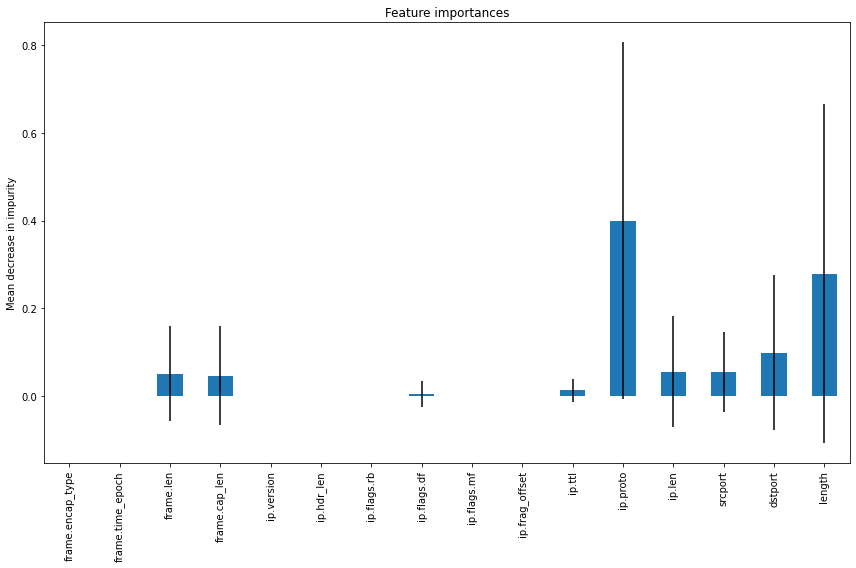

CPU times: user 530 ms, sys: 87.2 ms, total: 617 ms
Wall time: 314 ms


In [53]:
%%time

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

features = list(clean_dataset.columns)
classifier_importances = pd.Series(importances, index=features)
print(classifier_importances)

fig, ax = plt.subplots()
classifier_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout(rect=(0, 0, 2, 2))
plt.show()


Gradient boosting


In [54]:
%%time

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

model = GradientBoostingClassifier(random_state=0)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

# Not quic packet
print("Model predicted non quic packet: ", model.predict([[1,1644570362.781311,1474,1474,4,20,0,1,0,0,57,6,1460,5986,61023,32]]))
# Quic packet
print("Model predicted quic packet: ", model.predict([[1,1644570363.992292,87,87,4,20,0,0,0,0,64,17,73,54983,443,53]]))

# Save the model to file.
joblib.dump(model, path.join("models", "GradientBoostingClassifier"))

print(classification_report(Y_test, predictions))
score = model.score(X_test, Y_test) * 100
metrics["GradientBoostingClassifier"] = {"Accuracy": score}
print("Acuracy: {0}%".format(score))

# scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
# print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))

Model predicted non quic packet:  [0]
Model predicted quic packet:  [1]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       486
           1       0.99      1.00      1.00      1005

    accuracy                           0.99      1491
   macro avg       1.00      0.99      0.99      1491
weighted avg       0.99      0.99      0.99      1491

Acuracy: 99.3963782696177%
CPU times: user 272 ms, sys: 5.22 ms, total: 278 ms
Wall time: 276 ms


/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [55]:
%%time

from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report

model = BernoulliNB()
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

# Not quic packet
print("Model predicted non quic packet: ", model.predict([[1,1644570362.781311,1474,1474,4,20,0,1,0,0,57,6,1460,5986,61023,32]]))
# Quic packet
print("Model predicted quic packet: ", model.predict([[1,1644570363.992292,87,87,4,20,0,0,0,0,64,17,73,54983,443,53]]))

# Save the model to file.
joblib.dump(model, path.join("models", "BernoulliNB"))

print(classification_report(Y_test, predictions))
score = model.score(X_test, Y_test) * 100
metrics["BernoulliNB"] = {"Accuracy": score}
print("Acuracy: {0}%".format(score))

# scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
# print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))

Model predicted non quic packet:  [1]
Model predicted quic packet:  [1]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       486
           1       0.67      1.00      0.81      1005

    accuracy                           0.67      1491
   macro avg       0.34      0.50      0.40      1491
weighted avg       0.45      0.67      0.54      1491

Acuracy: 67.40442655935614%
CPU times: user 21 ms, sys: 3.67 ms, total: 24.7 ms
Wall time: 22.6 ms


/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F

Plot


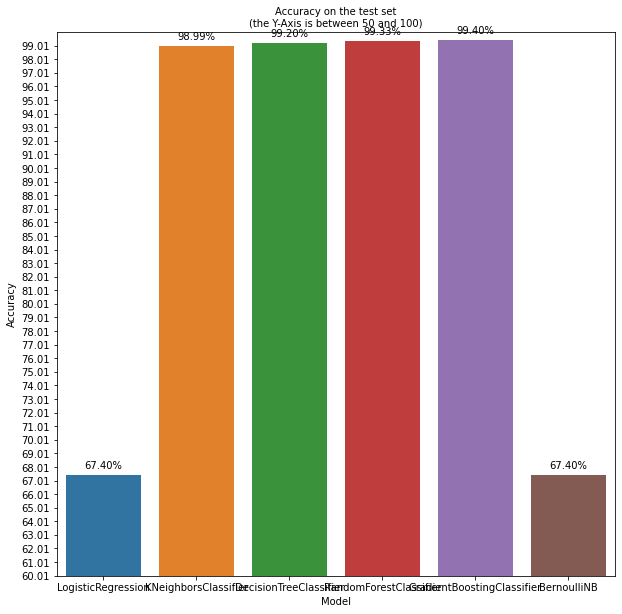

In [56]:
ticks = []
model = [
    "LogisticReg",
    "KNN",
    "Decision Tree",
    "RandomForest",
    "GradientBoosting",
    "Naive Bayes",
]
accuracy = []
models_accuracy = []
for k, v in metrics.items():
    accuracy.append(v["Accuracy"])
    models_accuracy.append([k, v["Accuracy"]])

df_acc = pd.DataFrame(models_accuracy)
df_acc.columns = ["Model", "Accuracy"]

plt.figure(figsize=(10, 10))
g = sns.barplot(x="Model", y="Accuracy", data=df_acc)
for i in range(0, 100):
    val = i + 0.01
    ticks.append(val)
g.set_yticks(ticks)
g.set_yticklabels(ticks)

plt.title("Accuracy on the test set\n(the Y-Axis is between 50 and 100)", fontsize=10)
plt.ylim(60, 100)
i = 0
for p in g.patches:
    percentage = "{:.2f}%".format(accuracy[i])
    x = p.get_x() + (p.get_width() / 2)
    y = p.get_height() + 0.5
    g.annotate(percentage, (x, y), ha="center")
    i = i + 1
    if i > 5:
        break

plt.show()
